In [ ]:
import itertools
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import accuracy_score, mean_squared_error as mse
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load data
xtrain = pd.read_csv('/content/drive/MyDrive/Deep Learning đồ án/Ventilator-pressure dataset/train.csv')
xtest = pd.read_csv('/content/drive/MyDrive/Deep Learning đồ án/Ventilator-pressure dataset/test.csv')

In [ ]:
xgr = xtrain.groupby('breath_id')['u_in']
xtrain['last_value_u_in'] = xgr.transform('last')
xtrain['u_in_cumsum'] = xgr.cumsum()
xtrain['u_in_lag1'] = xgr.shift(1)
xtrain['u_in_lag_back1'] = xgr.shift(-1)
xtrain.fillna(0, inplace=True)

xtrain['R'] = xtrain['R'].astype(str)
xtrain['C'] = xtrain['C'].astype(str)
xtrain = pd.get_dummies(xtrain)
del xgr
print(xtrain.shape)

(6036000, 16)


In [ ]:
#clean up the data
ytr_ref = xtrain['pressure'].copy()
# unibreath_tr = xtrain['breath_id'].unique()

ytrain = xtrain['pressure'].copy()
id_train = xtrain['id']
breathid = xtrain['breath_id']
uout = xtrain['u_out']
xtrain.drop(['pressure', 'id', 'breath_id'], axis=1, inplace=True)

In [ ]:
print(xtrain.shape, ytrain.shape)

# scale
RS = RobustScaler()
xtrain = RS.fit_transform(xtrain)

# reshape to [batch size, time steps, dimensionality]
xtrain = xtrain.reshape(-1, 80, xtrain.shape[-1])
ytrain = ytrain.to_numpy().reshape(-1, 80)

print(xtrain.shape, ytrain.shape)

(6036000, 13) (6036000,)
(75450, 80, 13) (75450, 80)


# Define the loss functions. Here we only need the L1 loss: |f(x) - y|.

In [ ]:
# loss.py: Define the loss functions (here we only need the L1 loss)
import torch
import torch.nn.functional as F

class weighted_l1_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):        
        weights = GetWeights(y_true, reweight=args.reweight, lds=args.lds, lds_kernel=args.lds_kernel, lds_ks=args.lds_ks, lds_sigma=args.lds_sigma )
        return np.mean(abs(y_true-y_pred)*weights)
def weighted_mse_loss(inputs, targets, weights=None):
    loss = (inputs - targets) ** 2
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

# def weighted_l1_loss(inputs, targets, weights=None):
#     loss = F.l1_loss(inputs, targets, reduction='none')
#     if weights is not None:
#         loss *= weights.expand_as(loss)
#     loss = torch.mean(loss)
#     return loss

def weighted_focal_mse_loss(inputs, targets, weights=None, activate='sigmoid', beta=.2, gamma=1):
    loss = (inputs - targets) ** 2
    loss *= (torch.tanh(beta * torch.abs(inputs - targets))) ** gamma if activate == 'tanh' else \
        (2 * torch.sigmoid(beta * torch.abs(inputs - targets)) - 1) ** gamma
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_focal_l1_loss(inputs, targets, weights=None, activate='sigmoid', beta=.2, gamma=1):
    loss = F.l1_loss(inputs, targets, reduction='none')
    loss *= (torch.tanh(beta * torch.abs(inputs - targets))) ** gamma if activate == 'tanh' else \
        (2 * torch.sigmoid(beta * torch.abs(inputs - targets)) - 1) ** gamma
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_huber_loss(inputs, targets, weights=None, beta=1.):
    l1_loss = torch.abs(inputs - targets)
    cond = l1_loss < beta
    loss = torch.where(cond, 0.5 * l1_loss ** 2 / beta, l1_loss - 0.5 * beta)
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss


In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)
X_te, X_val, y_te, y_val = train_test_split(X_te, y_te, test_size=0.5, random_state=42)
print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)
print(X_te.shape, y_te.shape)

(60360, 80, 13) (60360, 80)
(7545, 80, 13) (7545, 80)
(7545, 80, 13) (7545, 80)


In [ ]:
# y_pred = model.predict(X_te)

236/236 [==============================] - 12s 19ms/step


In [ ]:
# print('mse: ',mse(y_pred, y_te))

mse:  0.6890570451215556


In [ ]:
# model.save('model_LSTM.h5')

In [ ]:
# model = load_model('/content/drive/MyDrive/Imbalanced Regression/model/model_LSTM.h5') ## Name of model for option 1

##Define some utility functions

##Define the data iterator (data loader)

In [ ]:
from torch.functional import split
# datasets.py: Define the data interator (data loader)
from scipy.ndimage import convolve1d
from scipy.ndimage import convolve1d, gaussian_filter1d
import os
import numpy as np
from torch.utils import data
from scipy.signal.windows import triang
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window

def GetWeights(labels, reweight='none', max_target=65, lds=False, lds_kernel='gaussian',lds_ks=5,lds_sigma=2):
  
  assert reweight in {'none', 'inverse', 'sqrt_inv'}
  assert reweight != 'none' if lds else True, \
    "Set reweight to \'sqrt_inv\' (default) or \'inverse\' when using LDS"
  value_dict = {x: 0 for x in range(-1,max_target)}
  labels = np.squeeze(labels.reshape(labels.shape[0]*labels.shape[1], 1).tolist())
  
  #mbr
  for label in labels:
    value_dict[min(max_target-1, int(label))] += 1
  if reweight == 'sqrt_inv':
    value_dict = {k: np.sqrt(v) for k, v in value_dict.items()}
  elif reweight == 'inverse':
    value_dict = {k: np.clip(v, 5, 1000) for k, v in value_dict.items()}
  num_per_label = [value_dict[min(max_target-1, int(label))] for label in labels]
  if not len(num_per_label) or reweight == 'none':
    return None
  print(f"using re-weighting: [{reweight.upper()}]")
  if lds:
    lds_kernel_window = get_lds_kernel_window(lds_kernel, lds_ks, lds_sigma)
    print(f"Using LDS: [{lds_kernel.upper()}] ({lds_ks}/{lds_sigma})")
    smoother_value = convolve1d(np.asarray([v for _,v in value_dict.items()]), weights=lds_kernel_window, mode='constant')
    num_per_label = [smoother_value[min(max_target-1,int(label))] for label in labels]
  
  weights = [np.float64(1/x) for x in num_per_label]
  scaling = len(weights)/np.sum(weights)
  weights = [scaling*x for x in weights]
  # return np.array(weights).reshape(labels.shape[0], labels.shape[1])
  return np.array(weights)


##Set up some default configurations

In [ ]:
# train.py, Part 1: Set up some default configurations.
import time
import argparse
#import logging
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
from scipy.stats import gmean

import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

#from resnet import resnet50
# from fcnet import fcnet1
# from loss import *
# from datasets import BostonHousing
# from utils import *

import os
os.environ["KMP_WARNINGS"] = "FALSE"

parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# CPU only
parser.add_argument('--cpu_only', action='store_true', default=False, help='whether to use CPU only')
# imbalanced related
# LDS
parser.add_argument('--lds', action='store_true', default=False, help='whether to enable LDS')
parser.add_argument('--lds_kernel', type=str, default='gaussian',
                    choices=['gaussian', 'triang', 'laplace'], help='LDS kernel type')
parser.add_argument('--lds_ks', type=int, default=9, help='LDS kernel size: should be odd number')
parser.add_argument('--lds_sigma', type=float, default=1, help='LDS gaussian/laplace kernel sigma')
# re-weighting: SQRT_INV / INV
parser.add_argument('--reweight', type=str, default='none', choices=['none', 'sqrt_inv', 'inverse'], help='cost-sensitive reweighting scheme')

# training/optimization related
parser.add_argument('--dataset', type=str, default='ventilator pressure', choices=['imdb_wiki', 'agedb'], help='dataset name')
# parser.add_argument('--data_dir', type=str, default='./housing.data', help='data directory')
parser.add_argument('--model', type=str, default='', help='model name')
parser.add_argument('--store_root', type=str, default='checkpoint', help='root path for storing checkpoints, logs')
parser.add_argument('--store_name', type=str, default='', help='experiment store name')
parser.add_argument('--gpu', type=int, default=None)
parser.add_argument('--optimizer', type=str, default='adam', choices=['adam', 'sgd'], help='optimizer type')
parser.add_argument('--loss', type=str, default='l1', choices=['mse', 'l1', 'focal_l1', 'focal_mse', 'huber'], help='training loss type')
parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
parser.add_argument('--epoch', type=int, default=10, help='number of epochs to train')
parser.add_argument('--momentum', type=float, default=0.9, help='optimizer momentum')
parser.add_argument('--weight_decay', type=float, default=1e-4, help='optimizer weight decay')
parser.add_argument('--schedule', type=int, nargs='*', default=[60, 80], help='lr schedule (when to drop lr by 10x)')
#parser.add_argument('--batch_size', type=int, default=256, help='batch size')
parser.add_argument('--batch_size', type=int, default=64, help='batch size')
parser.add_argument('--print_freq', type=int, default=10, help='logging frequency')
parser.add_argument('--img_size', type=int, default=224, help='image size used in training')
parser.add_argument('--workers', type=int, default=32, help='number of workers used in data loading')
# checkpoints
parser.add_argument('--resume', type=str, default='', help='checkpoint file path to resume training')
parser.add_argument('--evaluate', action='store_true', help='evaluate only flag')

parser.set_defaults(augment=True)
args, unknown = parser.parse_known_args()

In [ ]:
class CFG:
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

##Train 4 different models using 4 options below

In [ ]:
# Option 1: To train the basic model, use the default setting, don't need to do anything
reweight = 'none'
lds = False

In [ ]:
# Option 2: To train the inverse weighting model:
reweight = 'inverse'

In [ ]:
# Option 3: To train the sqrt_inverse weighting model:
reweight = 'sqrt_inv'

In [ ]:
# Option 4: To train the Label Distribution Smoothing (LDS) model:
class args:
  reweight = 'sqrt_inv'
  lds = True
  lds_kernel = 'gaussian'
  lds_ls = 5
  lds_sigma = 2
  lds_ks = 9

##Train/Evaluate the model

In [ ]:
# train.py 
args.store_name = ''
args.start_epoch, args.best_loss=0, 1e5
if len(args.store_name):
  args.store_name = f'_{args.store_name}'
if not args.lds and args.reweight != 'none':
  args.store_name += f'_{args.reweight}'
if args.lds:
  args.store_name += f'_lds_{args.lds_kernel[:3]}_{args.lds_ks}'
  if args.lds_kernel in ['gaussian','laplace']:
    args.store_name += f'_{args.lds_sigma}'
args.store_name = f"{args.dataset}_{args.model}{args.store_name}_{args.loss}_{args.lr}_{args.batch_size}"

print(f"Args: {args}")
print(f"Store name: {args.store_name}")

train_loader = VentilatorPressure(x= X_tr, y= y_tr,reweight=args.reweight, lds=args.lds, lds_kernel=args.lds_kernel, lds_ks=args.lds_ks, lds_sigma=args.lds_sigma)

AttributeError: ignored

In [ ]:
train_weights = GetWeights(y_tr, reweight=args.reweight, lds=args.lds, lds_kernel=args.lds_kernel, lds_ks=args.lds_ks, lds_sigma=args.lds_sigma)

using re-weighting: [SQRT_INV]
Using LDS: [GAUSSIAN] (9/2)


IndexError: ignored

In [ ]:
y_tr.shape

(60360, 80)

In [ ]:
def Model():
  model = Sequential([Input(shape=xtrain.shape[-2:] ),
                      Bidirectional(LSTM(400, return_sequences=True)),
                      Bidirectional(LSTM(300, return_sequences=True)),
                      Bidirectional(LSTM(200, return_sequences=True)),
                      Bidirectional(LSTM(100, return_sequences=False)),
                      Dense(50, activation = 'selu'),
                      Dense(1)])
  
  model.compile(optimizer='adam',loss=weighted_l1_loss())
  return model

In [ ]:
model = Model()
scheduler = ExponentialDecay(1e-3, 400*((len(X_tr)*0.8)/CFG.BATCH_SIZE), 1e-5)
lr = LearningRateScheduler(scheduler, verbose=1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
model.fit(X_tr, y_tr, validation_data = (X_val, y_val), epochs = CFG.nepochs, 
              batch_size = CFG.BATCH_SIZE, callbacks = [early_stop , lr])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/6


TypeError: ignored

In [ ]:
# model.save('/content/drive/MyDrive/Imbalanced Regression/model/lds_LSTM.h5') ## Name of model for option 4 
model.save('/content/drive/MyDrive/Deep Learning đồ án/model/inverse_l1_0.001_64.h5') ## Option 2

In [ ]:
model = load_model('/content/drive/MyDrive/Deep Learning đồ án/model/inverse_l1_0.001_64.h5')

In [ ]:
y_pred=model.predict(X_te)

236/236 [==============================] - 8s 23ms/step


In [ ]:
y_pred=y_pred.reshape(y_pred.shape[0]*y_pred.shape[1],1)
y_te = y_te.reshape(y_te.shape[0]*y_te.shape[1],1)

##Evaluate 

In [ ]:
def short_metrics(preds, labels, train_labels, many_shot_thr=100000, low_shot_thr=10000):
  train_class_count, test_class_count = [], []
  mse_per_class, l1_per_class, r2_per_class = [], [], []
  for l in np.unique(np.floor(labels)):
    train_class_count.append(len(train_labels[np.floor(train_labels)==l]))
    test_class_count.append(len(labels[np.floor(labels)==l]))
    mse_per_class.append(np.sum((preds[np.floor(labels)==l]-labels[np.floor(labels)==l])**2))
    l1_per_class.append(np.sum(np.abs(preds[np.floor(labels)==l]-labels[np.floor(labels)==l])))
    r2_per_class.append(r2_score(labels[np.floor(labels)==l],preds[np.floor(labels)==l]))

  many_shot_mse, median_shot_mse, low_shot_mse = [], [], []
  many_shot_l1, median_shot_l1, low_shot_l1 = [], [], []
  many_shot_r2, median_shot_r2, low_shot_r2 = [], [], []
  many_shot_cnt, median_shot_cnt, low_shot_cnt = [], [], []
  for i in range(len(train_class_count)):
      if train_class_count[i] > many_shot_thr:
          many_shot_mse.append(mse_per_class[i])
          many_shot_l1.append(l1_per_class[i])
          many_shot_r2.append(r2_per_class[i])
          many_shot_cnt.append(test_class_count[i])
      elif train_class_count[i] < low_shot_thr:
          low_shot_mse.append(mse_per_class[i])
          low_shot_l1.append(l1_per_class[i])
          low_shot_r2.append(r2_per_class[i])
          low_shot_cnt.append(test_class_count[i])
      else:
          median_shot_mse.append(mse_per_class[i])
          median_shot_l1.append(l1_per_class[i])
          median_shot_r2.append(r2_per_class[i])
          median_shot_cnt.append(test_class_count[i])

  shot_dict = {}
  shot_dict['many mse'] = np.sum(many_shot_mse) / np.sum(many_shot_cnt)
  shot_dict['many l1'] = np.sum(many_shot_l1) / np.sum(many_shot_cnt)
  shot_dict['many r2'] = np.sum(many_shot_r2) / np.sum(many_shot_cnt)
  shot_dict['median mse'] = np.sum(median_shot_mse) / np.sum(median_shot_cnt)
  shot_dict['median l1'] = np.sum(median_shot_l1) / np.sum(median_shot_cnt)
  shot_dict['median r2'] = np.sum(median_shot_r2) / np.sum(median_shot_cnt)
  shot_dict['low mse'] = np.sum(low_shot_mse) / np.sum(low_shot_cnt)
  shot_dict['low l1'] = np.sum(low_shot_l1) / np.sum(low_shot_cnt)
  shot_dict['low r2'] = np.sum(low_shot_r2) / np.sum(low_shot_cnt)

  mse = mean_squared_error(preds, test_loader.y)
  mae = mean_absolute_error(preds, test_loader.y)
  r2 = r2_score(test_loader.y, preds)
  print(f" * Overall: MSE {mse:.3f}\tL1 {mae:.3f}\tR2 {r2:.3f}")
  print(f" * Many: MSE {shot_dict['many mse']:.3f}\t"
              f"L1 {shot_dict['many l1']:.3f}\tR2 score {shot_dict['many r2']:.3f}")
  print(f" * Median: MSE {shot_dict['median mse']:.3f}\t"
              f"L1 {shot_dict['median l1']:.3f}\tR2 score {shot_dict['median r2']:.3f}")
  print(f" * Low: MSE {shot_dict['low mse']:.3f}\t"
              f"L1 {shot_dict['low l1']:.3f}\tR2 score {shot_dict['low r2']:.3f}")

  return shot_dict

test_loader = VentilatorPressure(x= X_te, y= y_te,reweight=args.reweight, lds=args.lds, lds_kernel=args.lds_kernel, lds_ks=args.lds_ks, lds_sigma=args.lds_sigma)
shot_dict = short_metrics(y_pred,y_te, train_loader.y)

using re-weighting: [SQRT_INV]
Using LDS: [GAUSSIAN] (9/2)
 * Overall: MSE 0.735	L1 0.458	R2 0.989
 * Many: MSE 0.253	L1 0.289	R2 score -0.000
 * Median: MSE 1.755	L1 0.821	R2 score -0.003
 * Low: MSE 3.155	L1 1.191	R2 score -0.813


In [ ]:
y_pred.shape

(603600, 1)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
print(r2_score(y_te, y_pred))
print(mean_absolute_error(y_te,y_pred))

0.9887313762215733
0.4584763327313159


Result when using different options:
- Option 1: r2_score:                   , mae: 
- Option 2:
 * Overall: MSE 0.608	L1 0.431	R2 0.991
 * Many: MSE 0.209	L1 0.277	R2 score -0.000
 * Median: MSE 1.399	L1 0.752	R2 score -0.003
 * Low: MSE 3.756	L1 1.315	R2 score -1.264
- Option 4: r2_score: 0.9909020587112689, mae: 0.4216543379856877




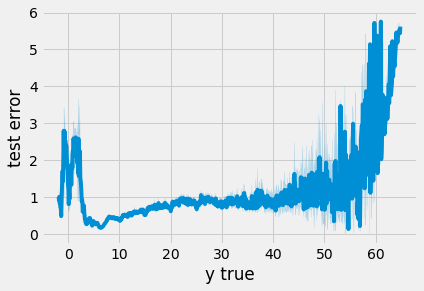

In [ ]:
import seaborn as sns
df = pd.DataFrame({'y true': np.squeeze(y_te), 'y pred': np.squeeze(y_pred)})
df['test error'] = abs(df['y pred'] - df['y true'])
sns.lineplot(data=df, x='y true', y='test error')